In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, normalized_mutual_info_score, 
    precision_recall_curve, auc, roc_curve, 
    accuracy_score, log_loss
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import Counter, defaultdict


In [2]:
BASE_DIR = './dataset/'
train = pd.read_csv(f'{BASE_DIR}train.csv')
train.fillna("", inplace=True)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
y_true = train['is_duplicate']
train.drop(['id','is_duplicate'], axis=1, inplace=True)
print(train.shape)

(404290, 4)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(train, y_true, stratify = y_true, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(283003, 4) (121287, 4) (283003,) (121287,)


In [5]:
## copied
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [6]:
## copied directly
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    """
    This function uses Seaborn Heatmap(s) to plot 3 different matrices. It plots the 
    Confusion Matrix, Precision Matrix and the Recall Matrix. The confusion matrix is as usual.
    In the Precision Matrix, the sum of the values in each column is 1. Similarly, in the
    Recall Matrix, the sum of the values in each row is 1.
    """
    
    C = confusion_matrix(test_y, predict_y)
    # Divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)
    # Divide each element of the confusion matrix with the sum of elements in that row
    B = (C/C.sum(axis=0))

    plt.figure(figsize=(12,10))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    
    # Representing C in heatmap format
    plt.subplot(2, 2, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # Representing B in heatmap format
    plt.subplot(2, 2, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    # Representing A in heatmap format
    plt.subplot(2, 2, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.886649848018065


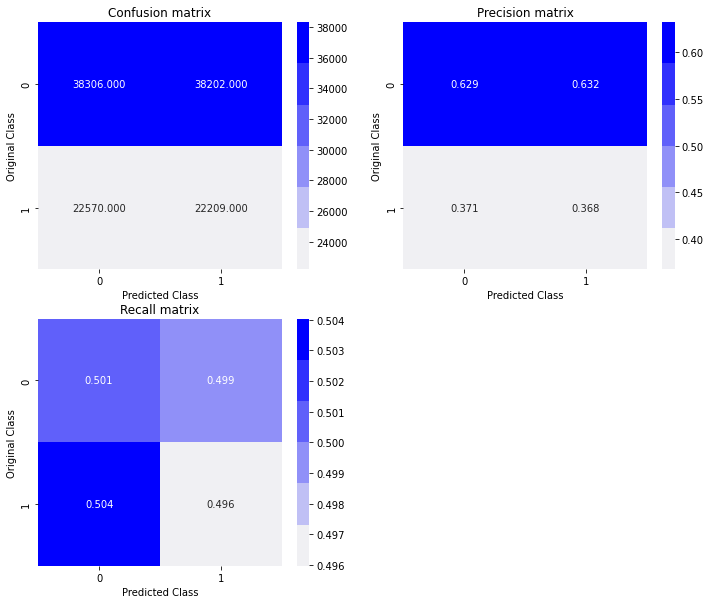

In [7]:
predicted_y = np.zeros((test_len, 2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test, predicted_y, eps=1e-15))

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Tf-Idf for classfiers

In [8]:
# Merge the Questions
questions = list(train['question1']) + list(train['question2'])

tfidf = TfidfVectorizer(min_df = 5, max_features = 500)
tfidf.fit(questions)

q1 = tfidf.transform(train['question1'])
q2 = tfidf.transform(train['question2'])
print(q1.shape, q2.shape)

(404290, 500) (404290, 500)


In [9]:
# Creating a DataFrame for the TF-IDF feature vectors
df3_q1 = pd.DataFrame.sparse.from_spmatrix(q1, index = train.index)
df3_q2 = pd.DataFrame.sparse.from_spmatrix(q2, index = train.index)
print(df3_q1.shape, df3_q2.shape)

(404290, 500) (404290, 500)


In [13]:
df = pd.concat((df3_q1, df3_q2), axis=1)
df.columns = list(range(1000))
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.323050,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.499787,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
404286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
404287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
404288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify = y_true, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(283003, 1000) (121287, 1000) (283003,) (121287,)


### Logistic Regression

In [15]:
# Hyper-parameters for SGD classifier
alpha = [10 ** x for x in range(-5, 2)] 

# Read more about SGDClassifier() at
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels = clf.classes_))
    print('Alpha:', i, "Log loss:", log_loss(y_test, predict_y, labels = clf.classes_))

Alpha: 1e-05 Log loss: 0.5711944785117599
Alpha: 0.0001 Log loss: 0.5715707425796963
Alpha: 0.001 Log loss: 0.5810620722721644
Alpha: 0.01 Log loss: 0.6050754122482003
Alpha: 0.1 Log loss: 0.6395248449408112
Alpha: 1 Log loss: 0.6463306108659945
Alpha: 10 Log loss: 0.6470263000340006


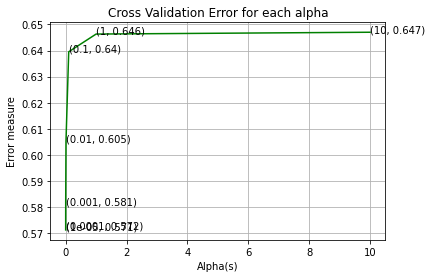

In [16]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha(s)")
plt.ylabel("Error measure")
plt.show()

In [17]:

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)



TypeError: file must have a 'write' attribute

In [18]:
# Saving the Model
pickle.dump(sig_clf, open('./models/analysis3/logistic_regression.pkl', "wb"))


In [20]:
# Loading the Model
sig_clf = pickle.load(open('./models/analysis3/logistic_regression.pkl', "rb"))

Best Alpha: 0.01, Train log loss: 0.5684539315675191
Best Alpha: 0.01, Test log loss: 0.5711944785117599
Total number of data points: 121287


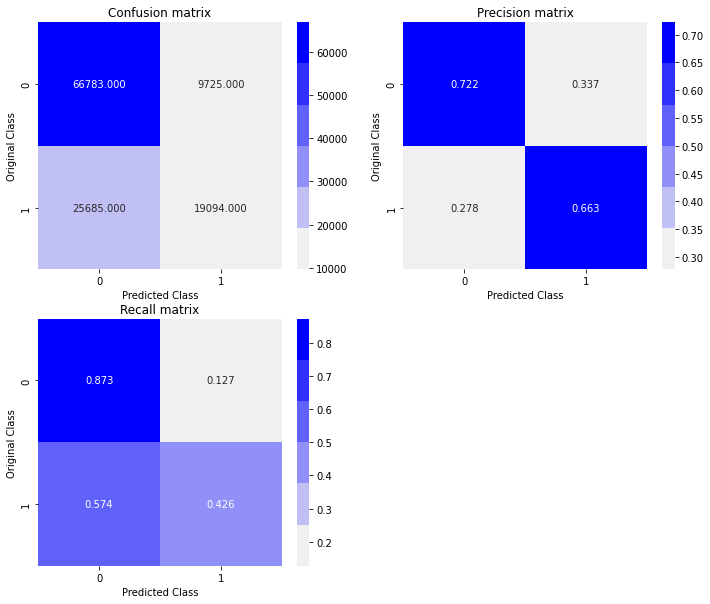

In [21]:
predict_y = sig_clf.predict_proba(X_train)
print("Best Alpha: 0.01, Train log loss:",log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print("Best Alpha: 0.01, Test log loss:",log_loss(y_test, predict_y, labels=sig_clf.classes_))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### SVM

In [22]:
# Hyper-parameters for SGD classifier
alpha = [10 ** x for x in range(-5, 2)]

# Read more about SGDClassifier() at
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('Alpha:', i, "Log loss:", log_loss(y_test, predict_y, labels = clf.classes_, eps=1e-15))


Alpha: 1e-05 Log loss: 0.5825536897598745
Alpha: 0.0001 Log loss: 0.6022348727165774
Alpha: 0.001 Log loss: 0.6411787351043571
Alpha: 0.01 Log loss: 0.65852782563227
Alpha: 0.1 Log loss: 0.6585278256322702
Alpha: 1 Log loss: 0.6585278256322701


In [ ]:

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha(s)")
plt.ylabel("Error measure")
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

In [ ]:
# Saving the Model
pickle.dump(sig_clf, open('./models/analysis3/linear_svm.pkl', "wb"))

In [ ]:
predict_y = sig_clf.predict_proba(X_train)
print("Best Alpha: 0.01, Train log loss:", log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print("Best Alpha: 0.01, Test log loss:", log_loss(y_test, predict_y, labels=sig_clf.classes_))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBoost

In [ ]:
xgbr = xgb.XGBClassifier(verbosity = 1, n_estimators = 150, max_depth = 15, 
    objective = 'binary:logistic', eval_metric = 'logloss')
xgbr.fit(X_train, y_train)

In [ ]:
# Saving the Model
pickle.dump(xgbr, open('./models/analysis3/xg_boost.pkl', 'wb'))

In [ ]:
predict_y = xgbr.predict_proba(X_train)
print("n_estimators: , max_depth: , Train log loss:", log_loss(y_train, predict_y, labels=[0,1]))
predict_y = xgbr.predict_proba(X_test)
print("n_estimators: , max_depth: , Test log loss:", log_loss(y_test, predict_y, labels=[0,1]))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)